In [1]:
# packages

import os
import numpy as np
import nibabel as nib
import pandas as pd
from nibabel.testing import data_path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# definint path

root = '/Users/loesvanvoorden/JupyterLocal/Thesis/OAS2_RAW_PART1/'

In [3]:
# defining different shapes for the images

full = pd.IndexSlice[:, :, :, 0]
half = pd.IndexSlice[::2, ::2, ::2, 0]
fourth = pd.IndexSlice[::4, ::4, ::4, 0]
eigth = pd.IndexSlice[::8, ::8, ::8, 0]
sixteenth = pd.IndexSlice[::16, ::16, ::16, 0]

full_shape = (256*256*128)
half_shape = (128*128*64)
fourth_shape = (64*64*32)
eigth_shape = (32*32*16)
sixteenth_shape = (16*16*8)

### Preprocessing

In [4]:
# opening reference excel file

excel_file = pd.read_excel('/Users/loesvanvoorden/Library/CloudStorage/OneDrive-Personal/BSc CSAI/CSAI year 3/S2 Thesis/oasis_longitudinal_demographics.xlsx')
data = pd.DataFrame(excel_file)
data.insert(15, 'Images', '')
data.insert(16, 'Cropped_1', '')
data.insert(17, 'Cropped_2', '')
data.insert(18, 'Cropped_3', '')
data.insert(19, 'Cropped_4', '')
data.insert(20, 'Cropped_5', '')
data.insert(21, 'Cropped_6', '')
data.insert(22, 'Cropped_7', '')
data.insert(23, 'Cropped_8', '')

# adding each (feature-reduced) image to the dataframe
for index, row in data.iterrows():
    for image in os.scandir(root+row['MRI ID']+'/RAW'):
        if image.name.endswith('img'):
            img = nib.load(image)
            data.at[index, 'Images'] = img.get_fdata()[fourth] # feature reduction
        # break because memory gets too large if every picture is added
        break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
 15  Images      373 non-null    object 
 16  Cropped_1   373 non-null    object 
 17  Cropped_2   373 non-null    object 
 18  Cropped_3   373 non-null    object 
 19  Cropped_4   373 non-null    o

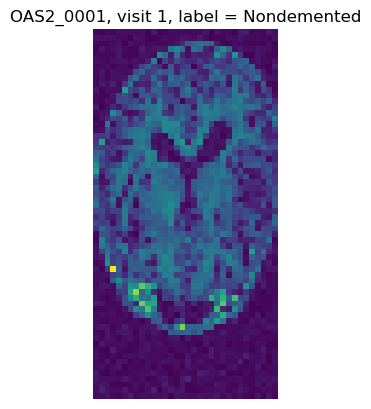

In [5]:
# info of put-together dataframe
print(data.info())

# how the first image, of the first visit, of the first patient is plotted:
plt.imshow(data.iloc[0]['Images'][:, 32, :])
plt.title(f"{data.iloc[0]['Subject ID']}, visit {data.iloc[0]['Visit']}, label = {data.iloc[0]['Group']}")
plt.axis('off')
plt.show()

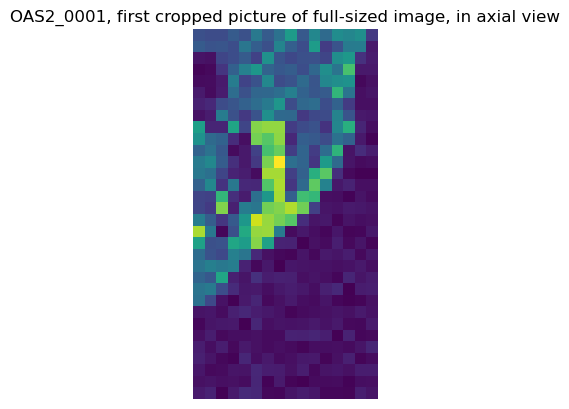

In [6]:
# cropping images and adding to data, full shape = (64, 64, 32)

for index, row in data.iterrows():
                                  
    img1 = data.iloc[index]['Images'][32:65, 0:32, 16:33]
    data.at[index, 'Cropped_1'] = img1
                                   
    img2 = data.iloc[index]['Images'][32:65, 32:65, 0:16]
    data.at[index, 'Cropped_2'] = img2
                                    
    img3 = data.iloc[index]['Images'][32:65, 32:65, 16:33]
    data.at[index, 'Cropped_3'] = img3
    
    img4 = data.iloc[index]['Images'][0:32, 32:65, 0:16]
    data.at[index, 'Cropped_4'] = img4
                     
    img5 = data.iloc[index]['Images'][0:32, 0:32, 16:33]
    data.at[index, 'Cropped_5'] = img5
                                   
    img6 = data.iloc[index]['Images'][0:32, 0:32, 0:16]
    data.at[index, 'Cropped_6'] = img6
    
    img7 = data.iloc[index]['Images'][32:65, 0:32, 0:16]
    data.at[index, 'Cropped_7'] = img7
               
    img8 = data.iloc[index]['Images'][0:32, 32:65, 16:33]
    data.at[index, 'Cropped_8'] = img8
    
plt.imshow(data.iloc[0]['Cropped_1'][:, 16, :])
plt.title(f"{data.iloc[0]['Subject ID']}, first cropped picture of full-sized image, in axial view")
plt.axis('off')
plt.show()

### Full sized images classification

In [7]:
# full-sized images 

from sklearn.model_selection import train_test_split
from sklearn import utils

# ratios of data
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

# converting to numpy because that is easier for algorithms
data_num = pd.DataFrame(data).to_numpy()

# defining images and target
for i in range(len(data_num[:, 15])):
    data_num[:, 15][i] = data_num[:, 15][i].reshape(fourth_shape)
    
X = data_num[:, 15]
# stacking so it gets the shape (373, 13702)
X = np.stack(X, axis=0)
y = data_num[:, 2]

# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio))


In [8]:
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {y.shape}")

The shape of X is (373, 131072)
The shape of y is (373,)


In [9]:
# KNN implementation for full-sized images

# testing for different amounts of neighbors
n_neighbors = [1, 3, 5, 7, 9, 11]

# creating lists to store scores
training_scores = {}
validation_scores = {}
test_scores = {}

# KNN for the different neighbors
for neighbor in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors = neighbor)
    clf.fit(X_train, y_train)
    training_scores[neighbor] = clf.score(X_train, y_train)
    validation_scores[neighbor] = clf.score(X_val, y_val)
    test_scores[neighbor] = clf.score(X_test, y_test)

# printing scores
fp = open("full_scores_KNN.txt", "a")
fp.write(f"training scores are: {training_scores}\n")
fp.write(f"validation scores are: {validation_scores}\n")
fp.write(f"test scores are: {test_scores}\n")
fp.write(f"Best test score is {max(test_scores.values())} with n_neighbor = {max(test_scores, key=test_scores.get)}\n\n")
fp.close()

In [50]:
# SVM implementation for full-sized images

# examine coefficience with SVM

Findings:

- The more clustered, the better the KNN test scores are. Why is this? 
- 

### Cropped pictures classification

In [10]:
# Cropped pictures 

# ratios of data
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

n_neighbors = [1, 3, 5, 7, 9, 11]

y = data_num[:, 2]
# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

# defining images and target for every cropped picture
for i in range(16, 24):
    for j in range(len(data_num[:, i])):
        data_num[:, i][j] = data_num[:, i][j].reshape(32*32*16)
    X = data_num[:, i]
    # stacking so it gets the shape (373, 16384)
    X = np.stack(X, axis=0)
    # splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio))

    # KNN for the cropped pictures

    # creating dicts to store scores with neighbors
    training_scores = {}
    validation_scores = {}
    test_scores = {}

    # KNN with different settings for n_neighbors
    for neighbor in n_neighbors:
        clf = KNeighborsClassifier(n_neighbors = neighbor)
        clf.fit(X_train, y_train)
        training_scores[neighbor] = clf.score(X_train, y_train)
        validation_scores[neighbor] = clf.score(X_val, y_val)
        test_scores[neighbor] = clf.score(X_test, y_test)

    fp = open("Cropped_scores_KNN.txt", "a")
    fp.write(f"Scores for {data.columns[i]}\n")
    # printing scores
    fp.write(f"training scores are: {training_scores}\n")
    fp.write(f"validation scores are: {validation_scores}\n")
    fp.write(f"test scores are: {test_scores}\n")
    fp.write(f"Best test score is {max(test_scores.values())} with n_neighbor = {max(test_scores, key=test_scores.get)}\n\n")
    fp.close()


In [11]:
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
num_neighbors = [1,3,5,7]

for neighbors in num_neighbors:
    fp = open("CV_scores_KNN.txt", "a")
    kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance'), X, y.ravel(), cv = 3, n_jobs = 3, return_train_score = True)
    fp.write(f"KNN with {neighbors} neighbors:\n{kNN_dict}\n")
    del kNN_dict
    fp.close()
""" 

'\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.model_selection import cross_validate\nnum_neighbors = [1,3,5,7]\n\nfor neighbors in num_neighbors:\n    fp = open("CV_scores_KNN.txt", "a")\n    kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbors, weights = \'distance\'), X, y.ravel(), cv = 3, n_jobs = 3, return_train_score = True)\n    fp.write(f"KNN with {neighbors} neighbors:\n{kNN_dict}\n")\n    del kNN_dict\n    fp.close()\n'